# Powerlaw package testing

Run some examples using the powerlaw package in Python for fitting power-law distributions.

In [54]:
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import powerlaw

We want to test which method is better for generating power-law distributions, either our old method or the new one using the `powerlaw` package.

First, we'll define the old method and then a generating function from the `powerlaw` package. There will be some iteration involved in the second approach since we cannot set $x_{max}$.

In [3]:
def power_law_old(n,a0,a1,alpha):
    x = np.random.rand(n)
    return ((a1**(alpha + 1.) - a0**(alpha + 1.))*x + a0**(alpha + 1.))**(1./(alpha + 1.))

In [22]:
def power_law_new(n,a0,a1,alpha):
    ytot = []
    pl = powerlaw.Power_Law(xmin=a0,parameters=[alpha])
    num_samples = n
    gt_xmax = 1
    while gt_xmax > 0:
        y = pl.generate_random(num_samples)
        ytot.extend(y[np.where(y<=a1)])
        gt_xmax = n - len(ytot)
        if gt_xmax < 10:
            num_samples = 10
        else:
            num_samples = int(np.ceil(gt_xmax/0.9))
    
    ytot = np.array(ytot)
    if gt_xmax < 0:
        return ytot[0:gt_xmax]
    else:
        return ytot

In [37]:
d_old = power_law_old(1000,0.001,0.1,-1.5)
d_new = power_law_new(1000,0.001,0.1,1.5)

In [39]:
fit_old = powerlaw.Fit(d_old)
fit_new = powerlaw.Fit(d_new)

Calculating best minimal value for power law fit
/opt/anaconda3/lib/python3.5/site-packages/powerlaw.py:692: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


In [40]:
fit_old.alpha,fit_old.xmin

(1.7120652217627848, 0.0011678333266817904)

In [41]:
fit_new.alpha,fit_new.xmin

(1.7158555214326197, 0.0010066840512087825)

In [42]:
len(d_old)
len(d_new)

1000

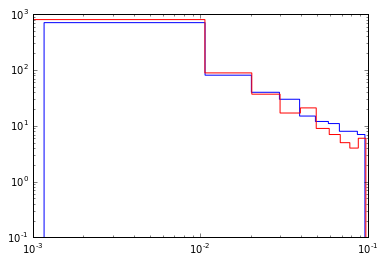

In [47]:
plt.hist(fit_old.data,log=True,histtype='step')
plt.hist(fit_new.data,log=True,histtype='step',color='r')
plt.xscale('log')

What if we try this out on some of our actual heating data.

In [51]:
def data_loader(species,alpha,loop_length,t_wait):
    top_dir = '/data/datadrive2/EBTEL_runs/%s_heating_runs/alpha%.1f/data/ebtel_L%.1f_tn%d_tpulse200.0_rka4'%(species,alpha,loop_length,t_wait)
    events = []
    for heat_file in os.listdir(top_dir):
        if 'heat_amp' in heat_file:
            temp = np.loadtxt(os.path.join(top_dir,heat_file))
            events.append(temp)
        else:
            continue
    return events

In [52]:
tn5000_events = data_loader('electron',1.5,40.0,5000)

In [71]:
all_events = np.array(list(itertools.chain(*tn5000_events)))
len(all_events)

10000

In [79]:
fit_events = powerlaw.Fit(all_events,xmin=0.1,xmax=1.)
fit_events.alpha,fit_events.xmin

(1.8928759071346692, 0.1)

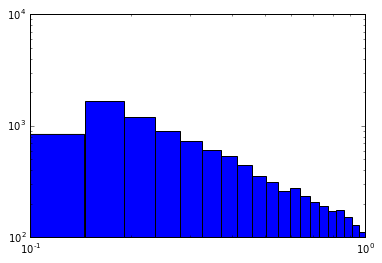

In [80]:
plt.hist(fit_events.data,log=True,bins=20)
plt.xscale('log')

## Fit $\mathrm{EM}$ using `powerlaw`

Test `powerlaw` package for fitting emission measure distributions.

First run the EBTEL model and then create the emission measure distribution.

In [81]:
#input dictionary
config_dict = {'usage_option':'dem','rad_option':'rk','dem_option':'new','heat_flux_option':'classical',
              'solver':'rka4','ic_mode':'st_eq','print_plasma_params':'True','heat_species':'electron'}
config_dict['total_time'] = 5000
config_dict['tau'] = 0.5
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0/6.0
config_dict['h_back'] = 3.5e-5
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 1.5
config_dict['loop_length'] = 40.0
config_dict['num_events'] = 1
config_dict['t_pulse_half'] = 100
config_dict['h_nano'] = 0.1
config_dict['sample_rate'] = 1
config_dict['output_file'] = os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/EBTEL/ebtel_data/pl_pack_testing')

In [90]:
from imp import reload
import sys
sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_C/bin'))
sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_analysis/src'))
import em_binner as emb
import ebtel_wrapper as ew
reload(emb)

<module 'em_binner' from '/home/wtb2/Documents/EBTEL_analysis/src/em_binner.py'>

In [83]:
ew.print_xml_config(config_dict,config_file=config_dict['output_file']+'.xml')

In [86]:
ew.run_ebtel('/home/wtb2/Documents/EBTEL-2fluid_repo/bin/','',config_file=config_dict['output_file']+'.xml')

In [88]:
tmp = np.loadtxt(config_dict['output_file']+'.txt')

In [91]:
binner = emb.EM_Binner(2.*config_dict['loop_length']*1e+8,time=tmp[:,0],temp=tmp[:,1],density=tmp[:,3])

In [92]:
binner.build_em_dist()

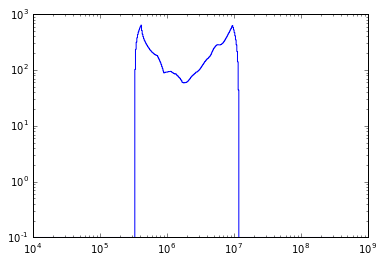

In [101]:
plt.hist(binner.T_em_flat,bins=binner.T_em_histo_bins,log=True,histtype='step')
plt.xscale('log')

In [94]:
emc_fit = powerlaw.Fit(binner.T_em_flat,xmin=10.**6,xmax=10.**6.6)

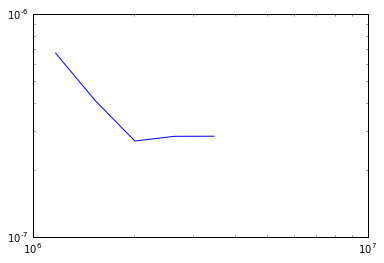

In [98]:
emc_fit.plot_pdf()

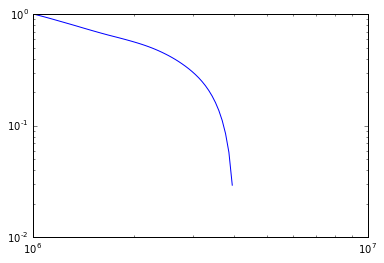

In [100]:
emc_fit.plot_ccdf()